<a href="https://colab.research.google.com/github/Rohan-crypt/DeepLearning/blob/main/Lab_2_(DL).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Exp 2.1 Basic Neural Network implemamntion for Application-specific classification task using tensorflow/pytorch

Steps:
1. Data collection/preparation of dataset/ Dataset selection
2. Data preprocessing
3. Build/create NN model
4. Training and testing
5. Performance evaluation

In [6]:
# Step 1: Data Collection / Preparation
import pandas as pd
import numpy as np
import tensorflow as tf

# Load your CSVs (update paths as needed)
train_df = pd.read_csv("train.csv")
test_df  = pd.read_csv("test.csv")

print("Train shape:", train_df.shape)
print("Test shape :", test_df.shape)
display(train_df.head())


Train shape: (2000, 21)
Test shape : (1000, 21)


,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


In [7]:
# Step 2: Data Preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Split features/labels (assume last column is target)
y_train_raw = train_df.iloc[:, -1].values
X_train_raw = train_df.iloc[:, :-1].values

y_test_raw  = test_df.iloc[:, -1].values
X_test_raw  = test_df.iloc[:, :-1].values

# Encode labels to integers if they are strings/categorical
le = LabelEncoder()
y_train = le.fit_transform(y_train_raw)
y_test  = le.transform(y_test_raw)

num_classes = len(np.unique(y_train))

# Scale numeric features (fit on train, apply to test)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test  = scaler.transform(X_test_raw)

# Convert to tf.data pipelines
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

def make_ds(features, labels, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices((features.astype("float32"), labels.astype("int32")))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(features))
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

train_ds = make_ds(X_train, y_train, shuffle=True)
test_ds  = make_ds(X_test,  y_test,  shuffle=False)

input_dim = X_train.shape[1]
print(f"Input dimension: {input_dim}, Classes: {num_classes}")


Input dimension: 20, Classes: 4


In [8]:
# Step 3: Build / Create NN Model (Keras)
from tensorflow import keras
from tensorflow.keras import layers

def build_model(input_dim, num_classes):
    inputs = keras.Input(shape=(input_dim,))
    x = layers.Dense(64, activation="relu")(inputs)
    x = layers.Dense(32, activation="relu")(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs, outputs, name="basic_classifier")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

model = build_model(input_dim, num_classes)
model.summary()


Model: "basic_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         1,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,556 (13.89 KB)

 Trainable params: 3,556 (13.89 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Step 4: Training
early_stop = keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=5, restore_best_weights=True
)

history = model.fit(
    train_ds,
    validation_data=test_ds,     # using provided test set as validation for simplicity
    epochs=50,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3557 - loss: 1.3327 - val_accuracy: 0.0080 - val_loss: 262.7321
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5968 - loss: 1.0187 - val_accuracy: 0.5070 - val_loss: 175.4329
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7354 - loss: 0.7288 - val_accuracy: 0.5070 - val_loss: 318.9235
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8354 - loss: 0.5370 - val_accuracy: 0.5070 - val_loss: 507.8216
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8886 - loss: 0.4005 - val_accuracy: 0.5070 - val_loss: 749.9003
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9203 - loss: 0.2972 - val_accuracy: 0.5070 - val_loss: 1006.0070
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9342 - loss: 0.2501 - val_accuracy: 0.5070 - val_loss: 1193.5170



Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       493
           1       0.51      1.00      0.67       507

    accuracy                           0.51      1000
   macro avg       0.25      0.50      0.34      1000
weighted avg       0.26      0.51      0.34      1000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


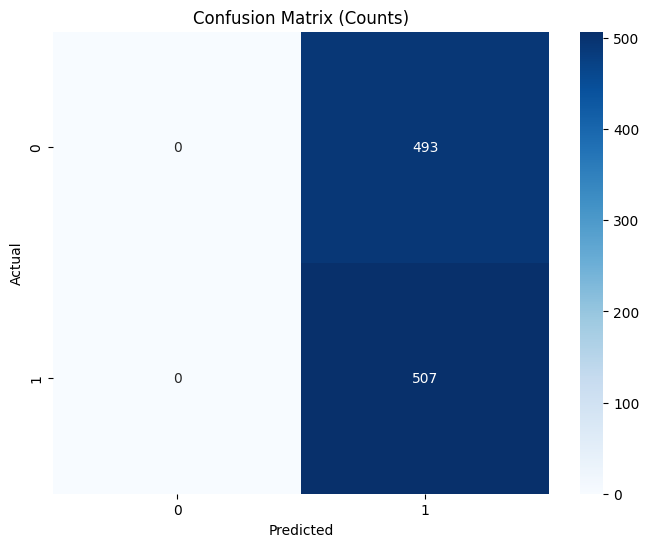

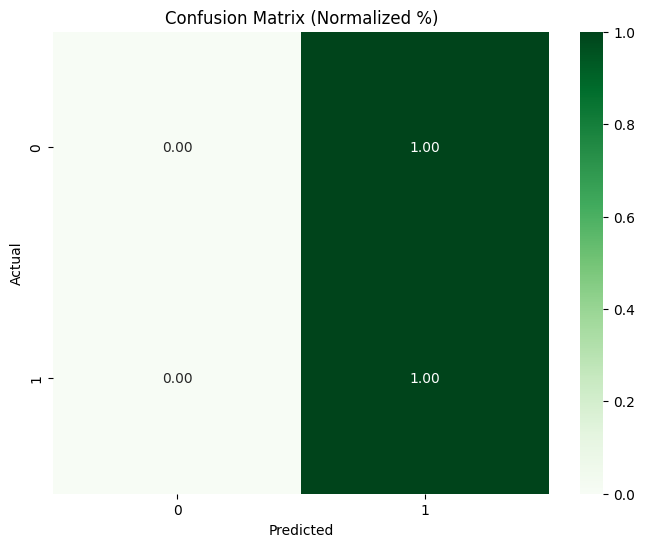

In [17]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ Get only the labels that actually appear in y_test or y_pred
present_labels = unique_labels(y_test, y_pred)
present_names = [str(le.classes_[i]) for i in present_labels]

# --- Classification Report ---
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred,
                            labels=present_labels,
                            target_names=present_names))

# --- Confusion Matrix (Counts) ---
cm = confusion_matrix(y_test, y_pred, labels=present_labels)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=present_names, yticklabels=present_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Counts)")
plt.show()

# --- Confusion Matrix (Normalized %) ---
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8,6))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Greens",
            xticklabels=present_names, yticklabels=present_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Normalized %)")
plt.show()
